# Project Summary: Message Analysis Toolkit
---

This document demonstrates a project in which I developed a toolkit for analyzing and visualizing message data. The project includes functions for cleaning and exploring text-based datasets, specifically those containing message information. The toolkit covers tasks such as word frequency analysis, message frequency trends over time, and visualizations such as heatmaps and scatterplots. Currently the toolkit is built for csv data exported from the messaging app Discord.

The motivation behind this project was to demonstrate my ability to perform exploratory data analysis using a range of python libraries. To demonstrate the capabilities of the toolkit, I utilised a personal dataset of text messages sent between my partner and I over an approximately 1.5 yr span.

The document exists in two parts:
## [Part 1: Module Imports and Function Definitions](#part-1-module-imports-and-function-definitions)

- ### Function List:
    - [`cleanDf(dl, column):`](#1-cleandf) Loads the specified dataset and performs data cleaning on a specified column in the dataset.
    - [`wordFreq(dl, column):`](#2-wordfreq) Calculates the frequency of each word in a specified column after cleaning the DataFrame.
    - [`messageByHour(dl, column):`](#3-messagebyhour) Extracts the hour information from a datetime column and adds an 'hour' column to the DataFrame.
    - [`barChartByHour(dl, column):`](#4-barchartbyhour) Creates a bar chart showing the message frequency by hour and saves it as a PNG file.
    - [`heatMap(dl):`](#5-heatmap) Creates a heatmap of message frequencies by hour and day of the week and saves it as a PNG file.
    - [`scatterplot(dl, reg=False):`](#6-scatterplot) Creates a scatterplot of message frequencies by minute of the day and saves it as a PNG file.
    - [`overTime(dl, plotType):`](#7-overtime) Plots the number of messages sent over time with options for scatter or line plot.
    - [`sentimentAnalysis:`](#8-sentimentAnalysis) Conducts a analysis of messages from each sender for overall negative or positive emotional tone.
 
## [Part 2: Code in action](#part-2-code-in-action)

- [`Scatterplot of Message Frequency according to time`](#1-scatterplot-of-message-frequency-according-to-time)
- [`Heatmap`](#2-heatmap)
- [`Messages over time`](#3-messages-over-time)

---

# Part 1: Module Imports and Function Definitions
---

## Importing neccessary libraries

In [61]:
#import libraries
import pandas as pd
import numpy as np
import string
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from datetime import datetime
from scipy import stats
import matplotlib.dates as mdates
from pandas import Timedelta
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

## Defining functions

### 1. CleanDf

In [62]:
def cleanDf(dl, column):
    """
    Loads the specified dataset and performs data cleaning on a specified column in the dataset.
    Parameters:
    - dl (str): File path or URL of the dataset in CSV format.
    - column (str): Name of the column in the dataset to be cleaned.
    Returns:
    - pd.DataFrame: Cleaned DataFrame.
    """
    
    # Check if input arguments are of the correct type
    if isinstance(dl, str) and isinstance(column, str):
        try:
            # Load the dataset into a Pandas DataFrame
            dl = pd.read_csv(dl)
            
            # Convert the values in the specified column to strings
            dl[column] = dl[column].values.astype(str)

            # Convert all text in the specified column to lowercase and remove punctuation
            dl[column] = dl[column].str.lower().str.replace('[{}]'.format(string.punctuation), '', regex=True)

            # Tokenize the text in the specified column using NLTK
            dl[column] = dl[column].apply(nltk.word_tokenize)

            # Remove stop words from the tokenized text using NLTK's English stop words
            stop_words = set(stopwords.words('english'))
            dl[column] = dl[column].apply(lambda x: [word for word in x if word not in stop_words])

            # Return the cleaned DataFrame
            return dl
        except FileNotFoundError:
            # Handle the case where the specified file is not found
            print("Error: file not found")
    else:
        # Handle the case where input types are incorrect
        print('File name and column must be strings')

### 2. wordFreq

In [63]:
def wordFreq(dl, column):
    """
    Calculates the frequency of each word in a specified column after cleaning the DataFrame.
    Parameters:
    - dl (str): File path or URL of the dataset in CSV format.
    - column (str): Name of the column in the dataset to analyze.
    Returns:
    - Counter: A Counter object containing word frequencies.
    """
    
    # Clean the DataFrame using the cleanDf function
    dl = cleanDf(dl, column)

    # Initialize a Counter to store word frequencies
    word_freq = Counter()

    # Update the word frequencies using the tokenized words in the specified column
    dl[column].apply(lambda x: word_freq.update(x))

    # Return the Counter object containing word frequencies
    return word_freq

### 3. messageByHour

In [64]:
def messageByHour(dl, column):
    """
    Extracts the hour information from a datetime column and adds an 'hour' column to the DataFrame.
    Parameters:
    - dl (str): File path or URL of the dataset in CSV format.
    - column (str): Name of the datetime column in the dataset.
    Returns:
    - pd.DataFrame: DataFrame with an additional 'hour' column.
    """
    
    # Load the dataset into a Pandas DataFrame
    dl = pd.read_csv(dl)

    # Convert the specified column to datetime
    dl[column] = pd.to_datetime(dl[column])

    # Extract the hour information and create a new 'hour' column
    dl['hour'] = dl[column].dt.hour

    # Return the DataFrame with the added 'hour' column
    return dl

### 4. barChartByHour

In [65]:
def barChartByHour(dl, column):
    """
    Creates a bar chart showing the message frequency by hour and saves it as a PNG file.
    Parameters:
    - dl (str): File path or URL of the dataset in CSV format.
    - column (str): Name of the datetime column in the dataset.
    Returns:
    - None
    """
    
    # Prepare the DataFrame by extracting the hour information
    dl = messageByHour(dl, column)

    # Create a bar chart using Seaborn
    sns.countplot(x='hour', data=dl)

    # Add title and labels to the chart
    plt.title('Message Frequency by Hour')
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Messages')

    # Save the chart as a PNG file
    plt.savefig('frequencyByHour.png')

    # Display the chart
    plt.show()

### 5. heatMap

In [66]:
def heatMap(dl):
    """
    Creates a heatmap of message frequencies by hour and day of the week and saves it as a PNG file.

    Parameters:
    - dl (str): File path or URL of the dataset in CSV format.

    Returns:
    - None
    """
    # Read the dataset into a Pandas DataFrame
    dl = pd.read_csv(dl)

    # Convert the 'Date' column to datetime
    dl['Date'] = pd.to_datetime(dl['Date'])

    # Extract day of the week and hour information
    dl['day'] = dl['Date'].dt.day_name()
    dl['hour'] = dl['Date'].dt.hour

    # Group by day and hour to get message counts
    heatmap_data = dl.groupby(['day', 'hour']).size().reset_index(name='count')

    # Define the order of days of the week
    days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

    # Ensure days are ordered correctly in the heatmap
    heatmap_data['day'] = pd.Categorical(heatmap_data['day'], categories=days_of_week, ordered=True)
    heatmap_data = heatmap_data.sort_values(by=['day', 'hour'])

    # Create a heatmap matrix
    heatmap_matrix = heatmap_data.pivot(index='hour', columns='day', values='count')

    # Plot the heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_matrix, linewidths=0.5, fmt='g')
    plt.title('Frequency of Messages by Hour and Day of Week')
    plt.xlabel('Day of Week')
    plt.ylabel('Hour of the Day')
    plt.savefig('heatmapByHour')

### 6. scatterplot

In [67]:
def scatterplot(dl, window_size=10):
    """
    Creates a scatterplot of message frequencies by minute of the day with a smoothing line (moving average).
    
    Parameters:
    - dl (str): File path or URL of the dataset in CSV format.
    - window_size (int): Size of the moving average window. Default is 10.
    
    Returns:
    - None
    """
    # Read the dataset into a Pandas DataFrame
    dl = pd.read_csv(dl)

    # Convert the 'Date' column to datetime
    dl['Date'] = pd.to_datetime(dl['Date'])

    # Calculate the minute of the day for each message
    dl['minute_of_day'] = dl['Date'].dt.hour * 60 + dl['Date'].dt.minute

    # Count the number of messages for each minute
    count = dl.groupby('minute_of_day')['Content'].count()

    # Apply moving average for smoothing
    smooth_line = count.rolling(window=window_size).mean()

    # Convert minute values to datetime for better x-axis labeling
    time_labels = pd.to_datetime(count.index, unit='m', origin='00:00:00')

    # Create the scatterplot with smoothing line
    plt.scatter(time_labels, count.values)
    plt.plot(time_labels, smooth_line, color='red')

    # Format x-axis labels to show time
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    # Add labels, title, and legend
    plt.xlabel('Time')
    plt.ylabel('Number of messages')
    plt.xticks(rotation=45)
    plt.legend()

    # Show the plot
    plt.show()

### 7. overTime

In [68]:
def overTime(dl, plotType):
    """
    Plots the number of messages sent over time with options for scatter or line plot.
    Parameters:
    - dl (str): File path or URL of the dataset in CSV format.
    - plotType (str): Type of plot ('scatter' or 'line').
    Returns:
    - None
    """
    # Read the dataset into a Pandas DataFrame
    dl = pd.read_csv(dl)

    # Convert the 'Date' column to datetime and set it as the index
    dl['Date'] = pd.to_datetime(dl['Date'])
    dl.set_index('Date', inplace=True)

    # Resample the data to daily counts
    daily_counts = dl['Content'].resample('D').count()

    # Plot either a scatter or line plot based on plotType
    if plotType == 'scatter':
        # Create an array 'x' and an array 'y' representing the indices and values of the 'daily_counts' df
        x = np.arange(len(daily_counts.index))
        y = daily_counts.values

        # Use NumPy's polyfit function to perform linear regression (fit a line)
        coefficients = np.polyfit(x, y, 1)

        # Define a polynomial (1st-degree) using obtained coefficients
        regression_line = np.poly1d(coefficients)

        # Generate y values for the regression line based on the x values
        y_regression = regression_line(x)
        
        # Create a scatter plot with regression line
        plt.figure(figsize=(10, 6))
        plt.scatter(daily_counts.index, y, label='Frequency of Messages', color='blue')
        plt.plot(daily_counts.index, y_regression, label='Regression Line', color='red')
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        
        # Calculate r squared value and define string
        r_squared = r_value**2
        r_squared_text = f'R-squared: {r_squared:.3f}'
        print(r_squared_text)
        
        # Define string to show p-value
        p_value_text = f'p-value: {p_value: .3f}'
        print(p_value_text)

    elif plotType == 'line':
        # Create a line plot of daily message counts
        plt.plot(daily_counts.index, daily_counts.values, linewidth=0.8)
    else:
        # Handle the case where an invalid plotType is provided
        return print("Error: Enter scatter or line")

    # Add labels and title
    plt.title('Number of Messages Sent Over Time')
    plt.xlabel('Date')
    plt.ylabel('Number of Messages')
    #plt.savefig('overTimeLine', dpi=300)
    plt.show()

### 8. sentimentAnalysis

In [69]:
def sentimentAnalysis(dl):
    """
    Analyzes sentiment for messages in a DataFrame and compares average sentiment across different senders.
    
    Parameters:
    - dl (str): File path or URL of the dataset in CSV format.
    
    Returns:
    - pd.DataFrame: DataFrame containing anonymized sender information, average sentiment, and sentiment category.
    """
    # Read the dataset into a Pandas DataFrame
    dl = pd.read_csv(dl)
    
    senders = dl['Author'].unique()
    anonymized_senders = ['Person ' + letter for letter in string.ascii_uppercase[:len(senders)]]

    comparison_data = []

    for sender, anonymized_sender in zip(senders, anonymized_senders):
        # Filter messages by sender
        sender_messages = dl[dl['Author'] == sender]['Content']

        # Analyse sentiment for each sender's messages
        sender_sentiments = sender_messages.apply(lambda text: TextBlob(str(text)).sentiment.polarity)

        # Calculate average sentiment for each sender, as a percentage
        sender_average_sentiment = sender_sentiments.mean()

        # Categorize sentiment for each sender's messages
        sender_categories = 'positive' if sender_average_sentiment > 0 else 'negative' if sender_average_sentiment < 0 else 'neutral'

        comparison_data.append({
            'Sender': anonymized_sender,
            'Average Sentiment': sender_average_sentiment,
            'Overall Sentiment Category': sender_categories
        })

    comparison_df = pd.DataFrame(comparison_data)

    return comparison_df

---
## Part 2: Code in action!
---

In this section I have used the previously defined function s to create insightful visualisations.
I will call these functions and explain the insights I believe each visualisation is providing us with.

### 1. Scatterplot of Message Frequency according to time

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


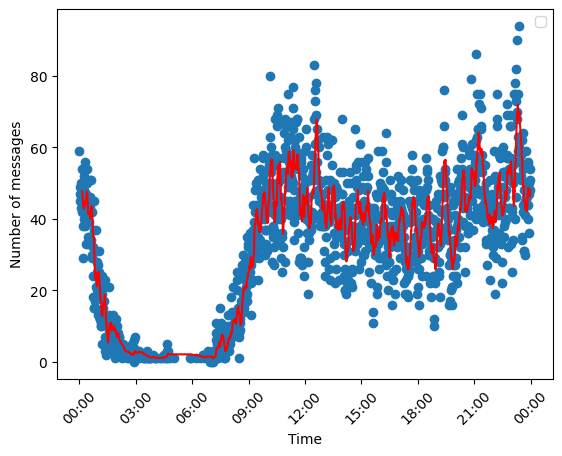

In [70]:
scatterplot('C:/Users/evie-/Python Data Science/Discord data analysis/discord2023.csv')

The x-axis of this scatterplot represents the time of day, while the y-axis represents the frequency of messages sent during those specific hours. A smoothing line was added to better visualise trends in messaging throughout the day.

As anticipated, the scatterplot reveals a discernible trend, with messaging activity peaking during daylight hours and tapering off significantly overnight.
The scatterplot suggests that daytime hours witness heightened interaction, possibly aligned with waking hours and daily activities.


### 2. Heatmap

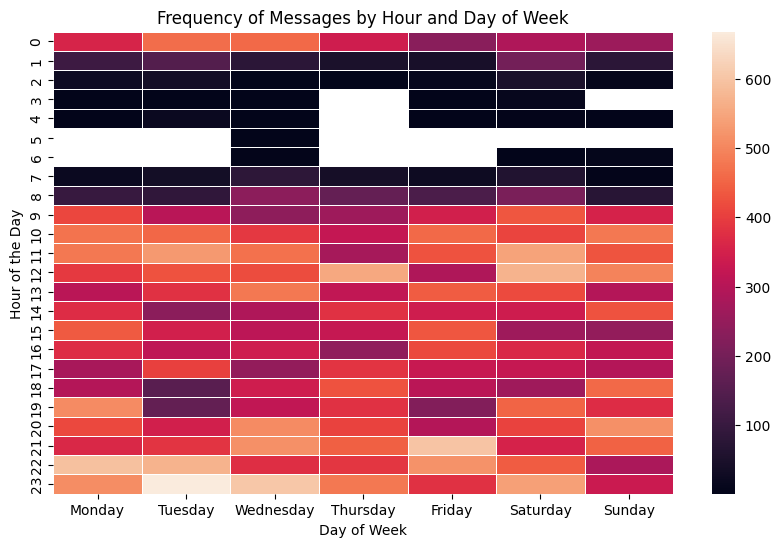

In [71]:
# Calling function with path to the dataset, to create heatmap
heatMap('C:/Users/evie-/Python Data Science/Discord data analysis/discord2023.csv')

This heatmap provides further visualisation for messaging trends according to time. It delves deeper, providing insights into the days of the week when messages were most frequently sent.
Similar to the scatterplot previously shown, this heatmap shows us a trend of peak messaging activity during the day, then a significant drop overnight.

However, unlike the scatterplot, this heatmap shows us 'hot spots' and 'cold spots' for messaging during the week. For example, Tuesday between the hours of 10 pm and 11 pm is a significant hot spot. 
Conversely, Tuesday between 6 pm and 7 pm is a significant cold spot.

This observed trend can be attributed to external factors related to my personal schedule during the approximately 1.5-year timeframe covered by the dataset. Specifically, my employment during this period involved working from 6 pm to 11 pm every Tuesday. Consequently, our messaging frequency was limited during those hours, but consistently increased once I had finished work.

While this insight may seem specific to the personal context of the dataset, I beleive it demonstrates my ability to identify and interpret patterns in data, using external knowledge to provide meaningful insights.

### 3. Messages over time

R-squared: 0.030
p-value:  0.000


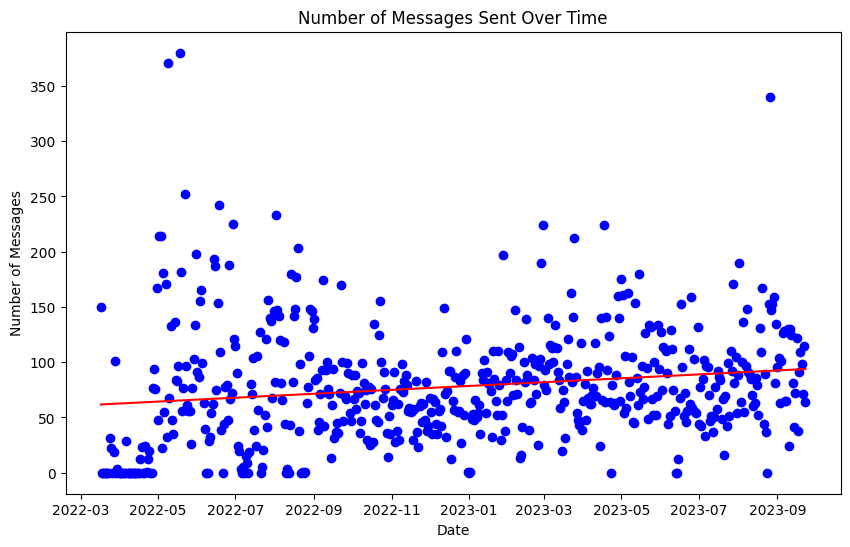

In [72]:
# Calling function with path to the dataset, to create scatterplot with regression line
overTime('C:/Users/evie-/Python Data Science/Discord data analysis/discord2023.csv','scatter')

This scatterplot demonstrates long-term trends in messaging. Each data point represents a different day. To see if the date could predict the frequency of messages sent in a day, a linear regression model was run. In this regression model,  the indepedent/predictor variable was the date, and the dependent/outcome variable was the number of messages sent in a day. The red line is a regression line, the slope of this line indicates the direction and steepness of the relationship between the indepedent and dependent variable.

From the regression model, a R-squared value of 0.03 was returned. This suggests that only approximately 3% of the variability in the number of messages can be explained by the passage of time. Therefore, the regression model with date as a predictor only captures a very small portion of the variablility in the frequency of messages sent in each day.

The p-value, which is less than 0.05, indicates that the observed correlation is statistically significant. This indicates that the observed correlation between time and the number of messages sent is unlikely to be purely due to random chance. Overall, although the regression model has statistical significance, the R-squared value of 0.03 indicates that the influence of the independent variable on the dependent variable is very small.

### 4. Sentiment analysis

In [73]:
# Calls a function which compares the overall sentiment of messages sent from each user
sentimentAnalysis('C:/Users/evie-/Python Data Science/Discord data analysis/discord2023.csv')

,Sender,Average Sentiment,Overall Sentiment Category
0,Person A,0.059680,positive
1,Person B,0.040544,positive


This shows an analysis of the messages from each sender for an overall positive or negative sentiment. Average sentiment scores were generated using a natural language processing (NLP) algorithm to analyse the emotional tone of the text.

The data frame above shows the average sentiment of each sender. Sentiment scores typically range from -1 to 1, with negative scores indicating negative sentiment, and positive scores indicating positive sentiment. 